In [1]:
from datetime import date, timedelta
from constants import *
from bars import plot_bars as plot_areas, unique_people_tested, daily_vaccinations, population_vaccinated
from phe import *
from phe import map_data as phe_map_data, latest_changes
from zoe import latest_map_data as zoe_map_data
from plotting import *
from vaccination import vaccination_dashboard, vaccination_changes
for_date = '*'

In [2]:
latest_changes(s.new_cases_sum, s.new_admissions_sum, s.new_deaths_sum)

Latest for England:
5,392 cases (7 day average) as of Wed 09 Jun, +253.0 since Tue 08 Jun
143 hospitalised (7 day average) as of Sat 12 Jun, +22.6 since Wed 09 Jun
6 died (7 day average) as of Wed 09 Jun, -0.4 since Tue 08 Jun


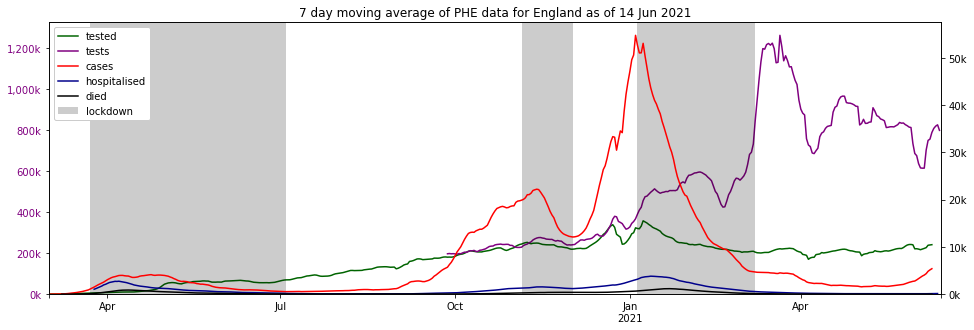

In [3]:
plot_summary(left_series=(s.unique_people_tested_sum, s.new_virus_tests_sum),
             right_series=(s.new_cases_sum, s.new_admissions_sum, s.new_deaths_sum))

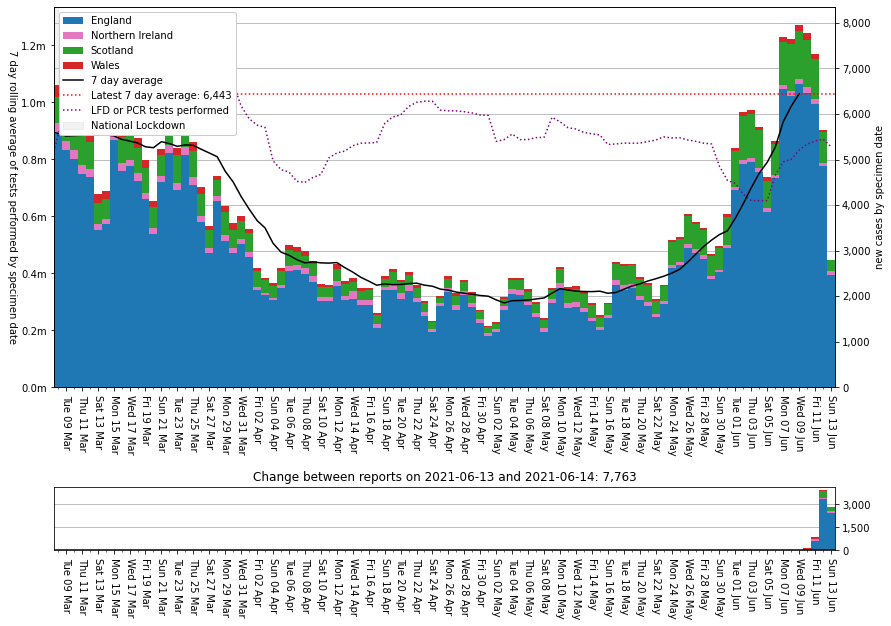

In [4]:
plot_areas(for_date, 'cases_nations', earliest=lockdown3[1], date_format='%a %d %b')

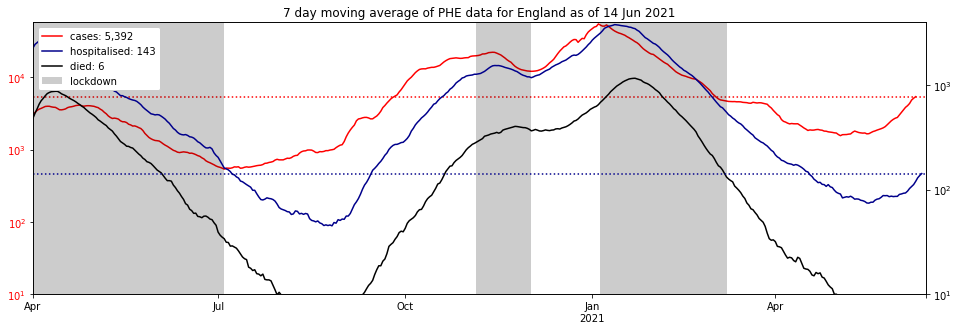

In [5]:
plot_summary(earliest_date='2020-04-01', show_latest='lines', log=True,
             left_series=(s.new_cases_sum,), left_formatter=per1k_formatter,
             right_series=(s.new_admissions_sum, s.new_deaths_sum), right_formatter=per0k_formatter)

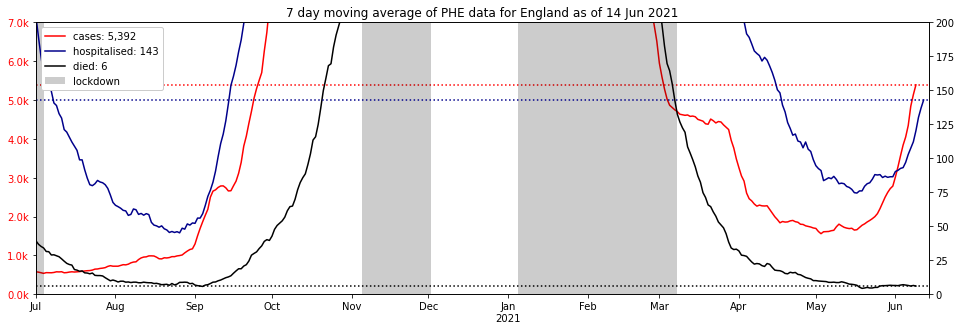

In [6]:
plot_summary(earliest_date='2020-07-01', show_latest='lines',
             left_series=(s.new_cases_sum,), left_formatter=per0k_formatter, left_ymax=7_000,
             right_series=(s.new_admissions_sum, s.new_deaths_sum), right_formatter=per0_formatter, right_ymax=200)

In [7]:
vaccination_changes()

,,Complete (Total),First Dose (Total),Second Dose (Total),Complete (New),First Dose (New),Second Dose (New)
,,,,,,,
England,13 Jun 21,"+25,391,916","+34,851,139","+25,391,916","+153,449","+123,866","+153,449"
Northern Ireland,13 Jun 21,"+750,356","+1,113,591","+750,356",+0,+0,+0
Scotland,13 Jun 21,"+2,446,834","+3,517,668","+2,446,834","+21,009","+20,381","+21,009"
Wales,13 Jun 21,"+1,384,673","+2,216,031","+1,384,673","+6,663","+2,981","+6,663"


,areaName,areaCode,full,any,partial,population,full_pct,partial_pct,none_pct
0,England,E92000001,25391916.0,34851139.0,9459223.0,56286961,45.111542,16.805354,38.083104
1,Northern Ireland,N92000002,750356.0,1113591.0,363235.0,1893667,39.624496,19.181567,41.193937
2,Scotland,S92000003,2446834.0,3517668.0,1070834.0,5463300,44.786741,19.600498,35.612762
3,Wales,W92000004,1384673.0,2216031.0,831358.0,3152879,43.917734,26.368218,29.714049


'partial: 41,698,429 (62.4%), full: 29,973,779'

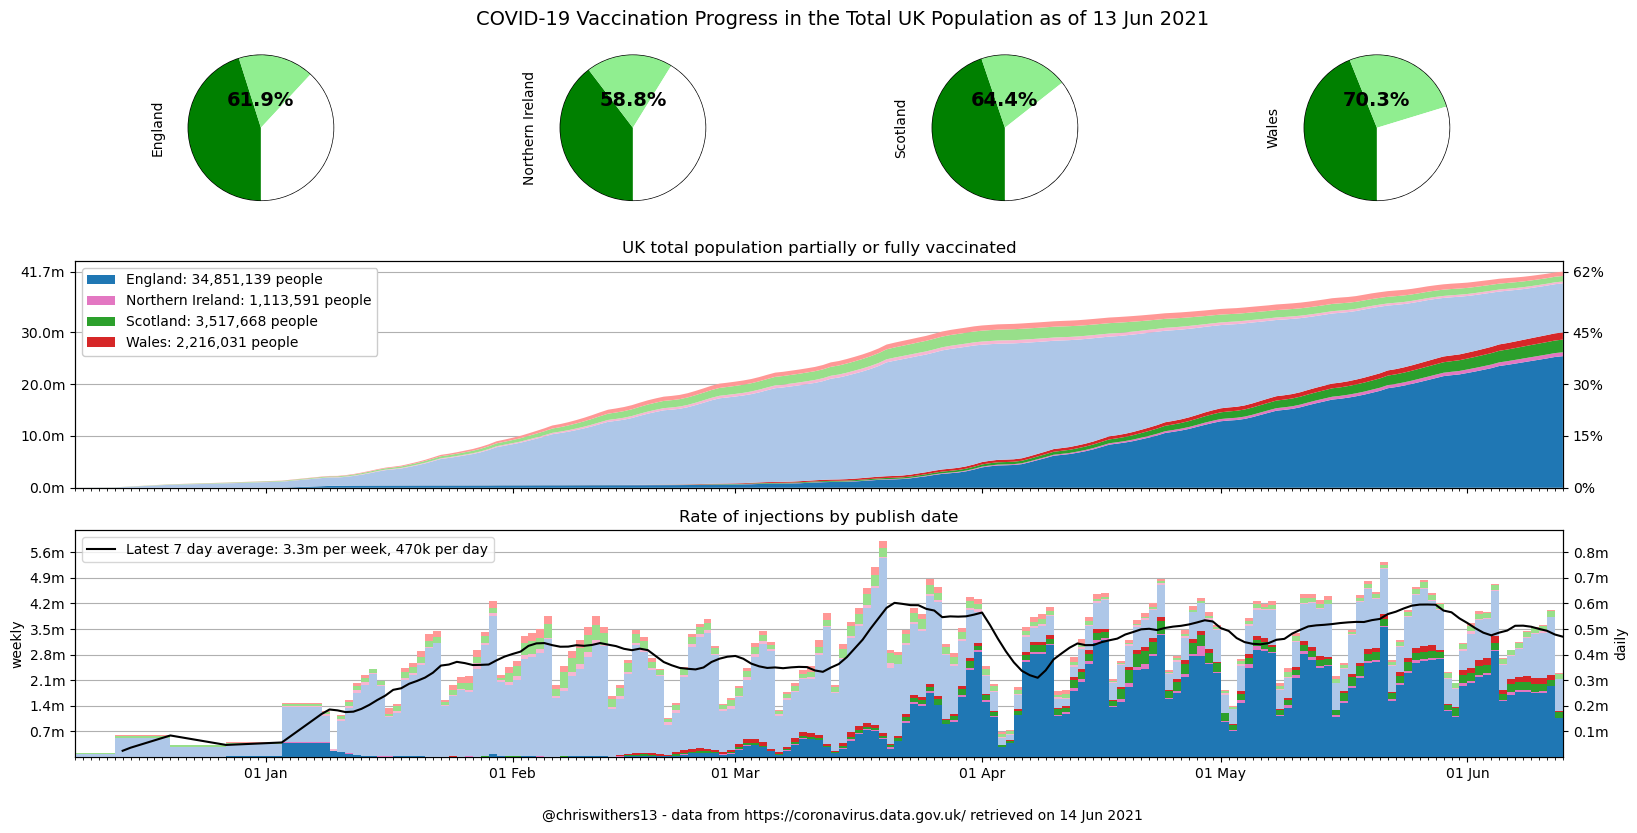

In [8]:
results = vaccination_dashboard()
partial = results['any'].sum()
population = results['population'].sum()
display(results, f"partial: {partial:,.0f} ({partial/population:.1%}), full: {results['full'].sum():,.0f}")

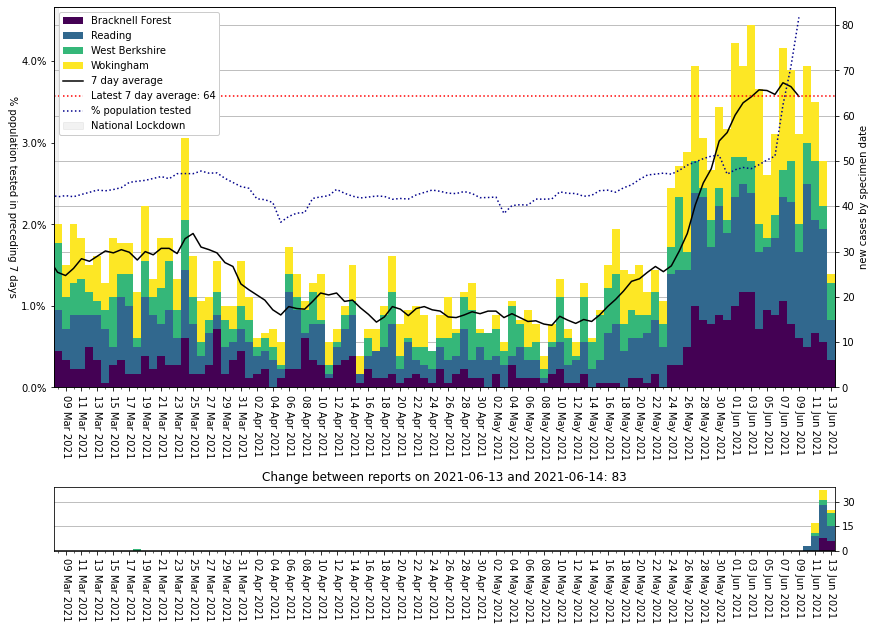

In [9]:
plot_areas(for_date, areas=my_areas, earliest=lockdown3[1], lines=unique_people_tested)

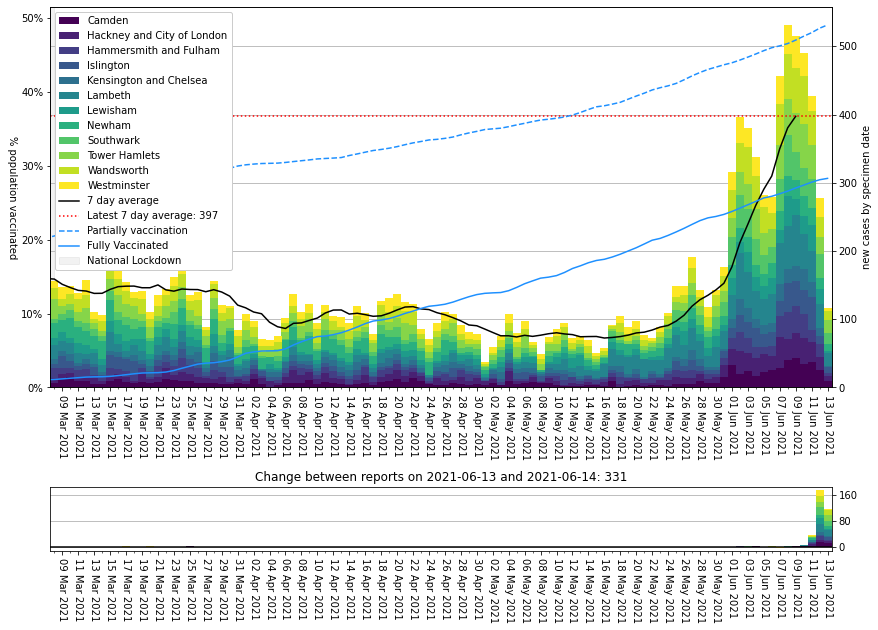

In [10]:
plot_areas(for_date, areas=london_areas, earliest=lockdown3[1], lines=population_vaccinated)

In [11]:
data = recent_phe_data_summed(for_date)
top_10_cols = [area_name,per100k,new_cases_by_specimen_date, specimen_date]

In [12]:
top_10 = data.sort_values(per100k, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
E06000008,Blackburn with Darwen,511.035699,765.0,2021-06-13
E07000124,Ribble Valley,440.152411,268.0,2021-06-13
E07000120,Hyndburn,430.635589,349.0,2021-06-13
E07000117,Burnley,359.874044,320.0,2021-06-13
E07000125,Rossendale,341.344674,244.0,2021-06-13
E08000006,Salford,304.442229,788.0,2021-06-13
E08000003,Manchester,299.353541,1655.0,2021-06-13
E07000122,Pendle,297.463957,274.0,2021-06-13
E07000123,Preston,280.853739,402.0,2021-06-13


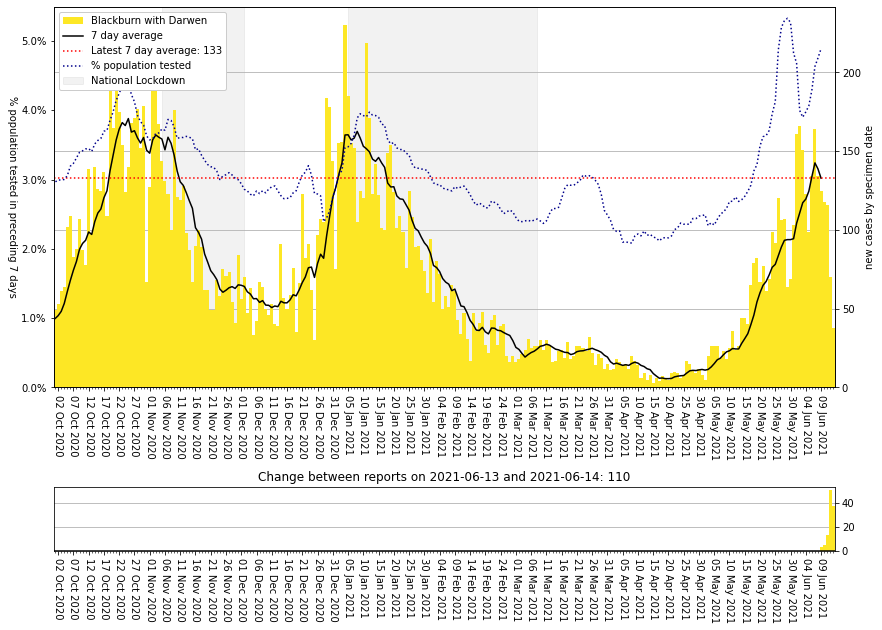

In [13]:
plot_areas(for_date, areas=[top_10.iloc[0].name], colormap='viridis_r', lines=unique_people_tested)

In [14]:
top_10 = data.sort_values(new_cases_by_specimen_date, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
E08000003,Manchester,299.353541,1655.0,2021-06-13
E08000035,Leeds,147.515127,1170.0,2021-06-13
E08000025,Birmingham,88.630743,1012.0,2021-06-13
S12000036,City of Edinburgh,181.548016,953.0,2021-06-13
S12000049,Glasgow City,142.784938,904.0,2021-06-13
E08000006,Salford,304.442229,788.0,2021-06-13
E06000008,Blackburn with Darwen,511.035699,765.0,2021-06-13
E08000010,Wigan,228.502230,751.0,2021-06-13
E08000001,Bolton,259.433142,746.0,2021-06-13


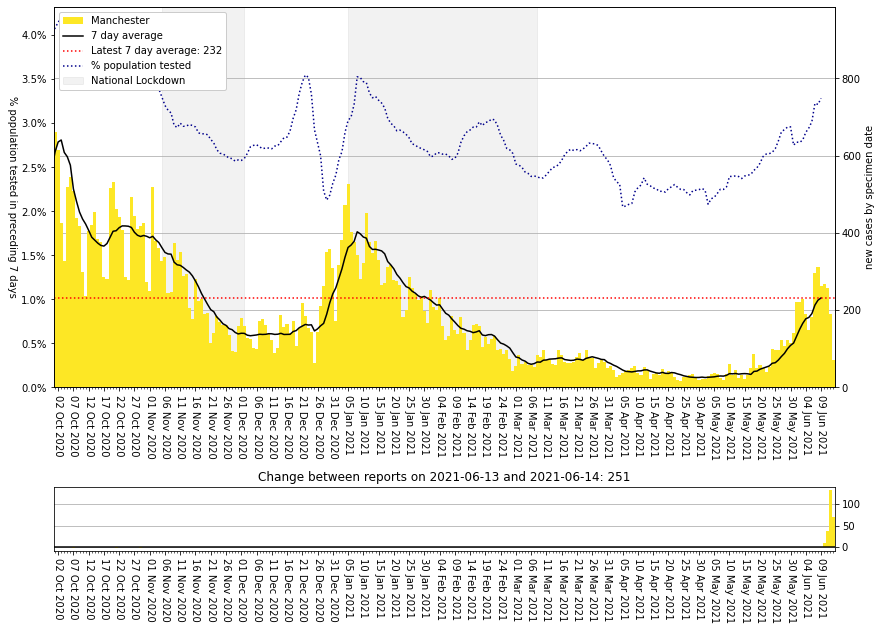

In [15]:
plot_areas(for_date, areas=[top_10.iloc[0].name], colormap='viridis_r', lines=unique_people_tested)

In [16]:
zoe_date, zoe_df = zoe_map_data()
phe_recent_date, phe_recent_geo, phe_recent_title = phe_map_data(for_date)
zoe_max = 2.5
phe_max = 0.5

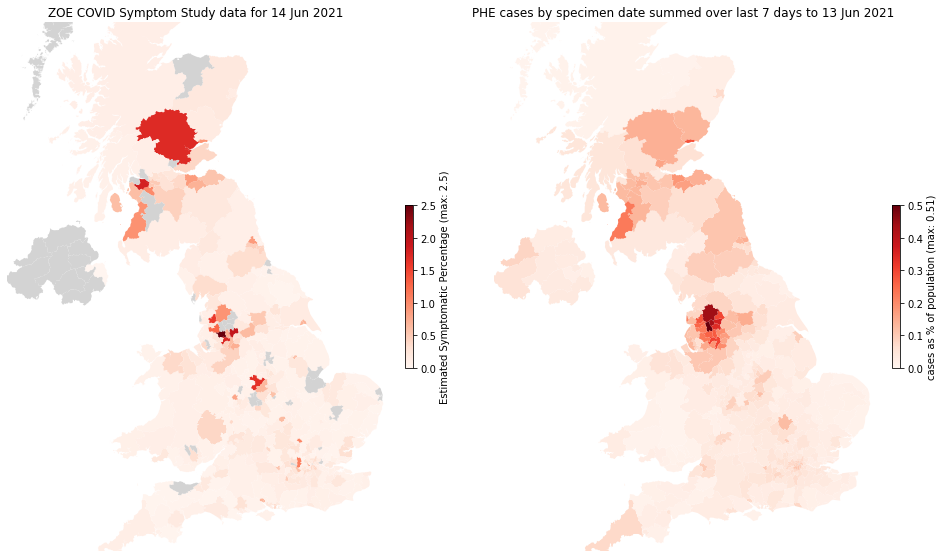

In [17]:
matplotlib_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

In [18]:
bokeh_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

Loading BokehJS ...